### Code for the SPI data visualization.

#### This code provides a easy way for the creation, ploting and exportation of maps, graphs and figures.

Developed by: Thiago Victor Medeiros do Nascimento

In [4]:
from pcraster import *
import numpy as np
from osgeo import gdal, gdalconst
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pylab as plt
import subprocess
import glob,os
import time
import rasterio
import tqdm

import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

import geopandas as gpd
import rioxarray as rxr

At this point the SPIs previously computed are load into this notebook.

In [4]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\spis'
filenames = glob.glob(path + "/*.csv")
filenames

['C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi01.csv',
 'C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi03.csv',
 'C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi06.csv',
 'C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi09.csv',
 'C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi12.csv',
 'C:\\Users\\User\\OneDrive\\Projects\\Y2022\\SPI-Rondonia\\rondonia\\spis\\spi24.csv']

It is possible to check what is the state of the data:

In [6]:
spi1 = pd.read_csv(filenames[0], header = None)
spi1.head()

,0,1,2,3,4,5,6,7,8,9,...,16320,16321,16322,16323,16324,16325,16326,16327,16328,16329
0,-0.632028,-0.571755,-0.609916,-0.623397,-0.653991,-0.834793,-0.831661,-0.853831,-0.809825,-0.831557,...,1.587986,1.767648,1.609914,1.313154,1.329627,1.741580,1.421555,1.376498,1.277517,1.089718
1,0.528737,0.263823,0.441300,0.408738,0.020749,-0.363975,-0.375792,-0.450851,-0.192780,-0.538381,...,0.045401,0.248212,0.421379,0.226639,0.220673,0.298241,0.217014,0.192054,0.260041,0.288650
2,-0.014420,0.103256,0.095881,0.110829,0.214394,0.287847,0.273673,0.213079,0.293681,0.266345,...,0.497349,0.457245,0.579175,0.370709,0.391034,0.501811,0.517437,0.528416,0.534137,0.515985
3,-0.678760,-1.075606,-0.725512,-0.762795,-0.093850,0.045663,-0.014279,0.060985,-0.467705,-0.143649,...,-1.314160,-1.121681,-1.605637,-1.702498,-1.742362,-1.827489,-1.783340,-1.794194,-1.442159,-1.127484
4,0.824800,1.147379,1.451848,1.477877,1.103469,1.259727,1.276979,1.277163,0.999554,0.980874,...,-2.316820,-2.272150,-2.294401,-2.135074,-2.183526,-2.439484,-2.875785,-2.803501,-2.402862,-2.856418


For this case study we are dealing with data from the state of Rondonia (Brazil). However, despite the SPI have been computed for a rectangle around the boundaries, for the statistical computations it is better to use only the area within the state's boundaries. Therefore we will provide a mask saved in .tif where we have values of 0 (outside the area) and different than zero (within the area). 

In [7]:
pathmask =r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\gis\maskspi.tif'
mapfilter = rasterio.open(pathmask)

# Here we may get the number of columns and rows from the raster data 
# (which has to be the same as the original precipitation dataset and SPIs)
ncols = mapfilter.width
nrows = mapfilter.height
numtotal = nrows*ncols

mapreadarray = mapfilter.read()[0,:,:]

# Here we set to 1 the values within the study area, and to np.nan the values outside the study area.
mapreadarray[mapreadarray != 0 ] = 1
mapreadarray[mapreadarray == 0 ] = np.nan

# Here we can perform a reshape of our data from a matrix (nrows, ncols) to a vector (1, nrows * ncols).
# This vector has the same format as the SPIs .CSV datasets
mapreadarrayres = np.reshape(mapreadarray, (1, numtotal))

#### (a) SPIs mean computation

At this part it is possible to compute the area's mean regarding each SPI:

In [8]:
# First we create a dataframe, where each colum will correspond to a different SPI mean:
spis = pd.DataFrame(columns = ["SPI_1", "SPI_3", "SPI_6", "SPI_9", "SPI_12", "SPI_24"])
spis["date"] = pd.date_range(start='1981/1/1', end = '2019/12/31', freq='M')
spis.set_index("date", inplace = True)

Now a for loop is used for the means computation. 

In [9]:
i = 0

for filename in tqdm.tqdm(filenames):
    
    spi = pd.read_csv(filenames[i], header = None)
    
    spis.iloc[:, i] = (spi * mapreadarrayres).T.mean().values
    i = i + 1

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.12s/it]


In [10]:
spis

,SPI_1,SPI_3,SPI_6,SPI_9,SPI_12,SPI_24
date,,,,,,
1981-01-31,0.451222,NaN,NaN,NaN,NaN,NaN
1981-02-28,0.077000,NaN,NaN,NaN,NaN,NaN
1981-03-31,-0.075659,0.205166,NaN,NaN,NaN,NaN
1981-04-30,-0.399725,-0.256110,NaN,NaN,NaN,NaN
1981-05-31,-0.038015,-0.335054,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-08-31,0.329816,-0.051404,-0.134985,0.573037,0.730512,0.553678
2019-09-30,-0.596462,-0.378712,-0.240041,0.207463,0.668037,0.514635
2019-10-31,0.716868,0.156549,-0.220886,0.338725,0.822252,0.636799


Save the dataframe in a .XLSX file:

In [11]:
spis.to_excel(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\spis\spismean.xlsx')

Graphs and plots:

#### (b) SPIs mean plots (all figures together): 

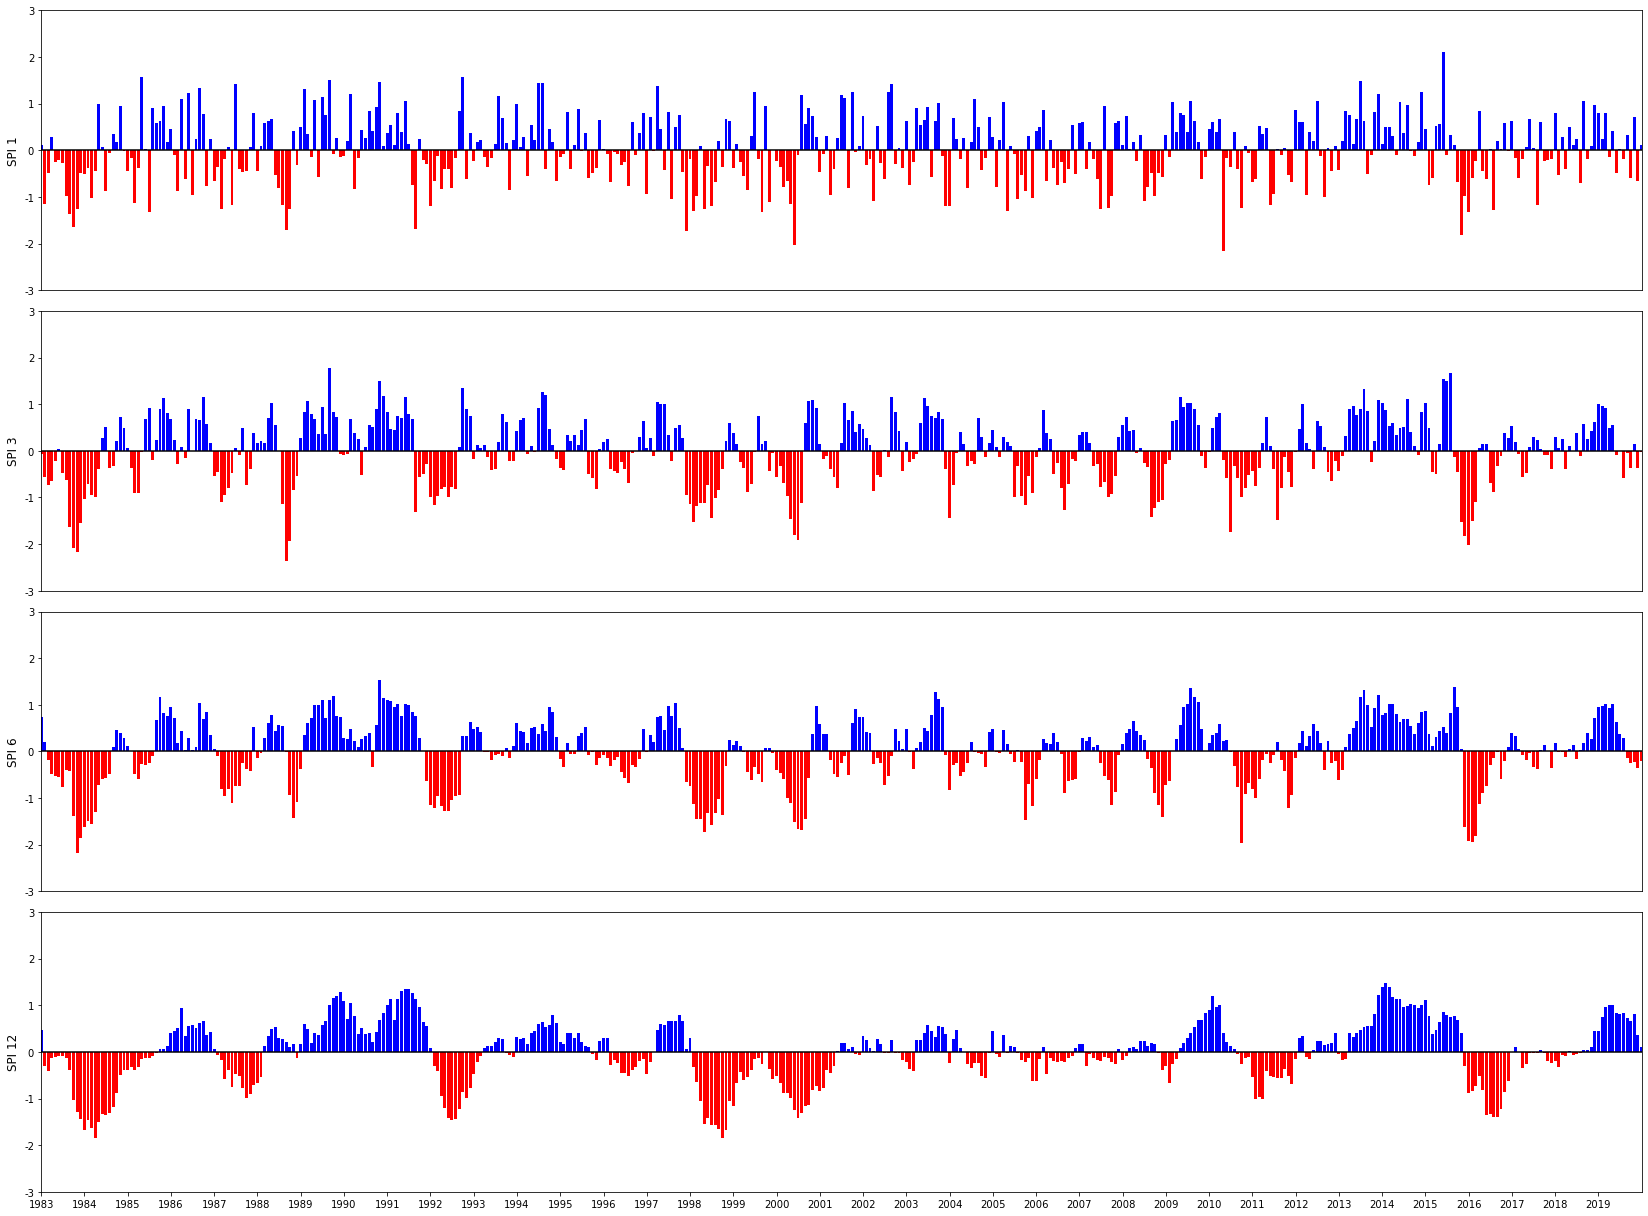

In [205]:
#tipos_de_spi = [1, 3, 6, 9, 12, 24]
tipos_de_spi = [1, 3, 6, 12]

fig, axes = plt.subplots(nrows=4, figsize=(23, 17))
plt.subplots_adjust(hspace=0.0)

for i, ax in enumerate(axes):
    
    col_scheme = np.where(spis['SPI_'+str(tipos_de_spi[i])] > 0, 'b','r')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.bar(spis.index, spis['SPI_'+str(tipos_de_spi[i])], width=25, align='center', color=col_scheme, label='SPI ' + str(tipos_de_spi[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    #ax.legend(loc='upper right')
    ax.tick_params(axis='x', rotation=0)
    ax.set_yticks(range(-3,4), range(-3,4))
    ax.set_ylabel('SPI '+str(tipos_de_spi[i]), fontsize=12)
    
    ax.set_yticks(range(-3,4), range(-3,4))
    
    ax.set_xlim(dt.date(1983, 1, 1), dt.date(2019, 12, 31))
    
    if i<len(tipos_de_spi)-1:
        ax.set_xticks([],[])

plt.tight_layout()

In [206]:
fig.get_figure().savefig(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs\spis.jpeg',dpi=300)

#### (b) SPIs mean plots (individual figures): 

Now as we are saving several figures, we define a path output where those figures will be saved.

In [208]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs'

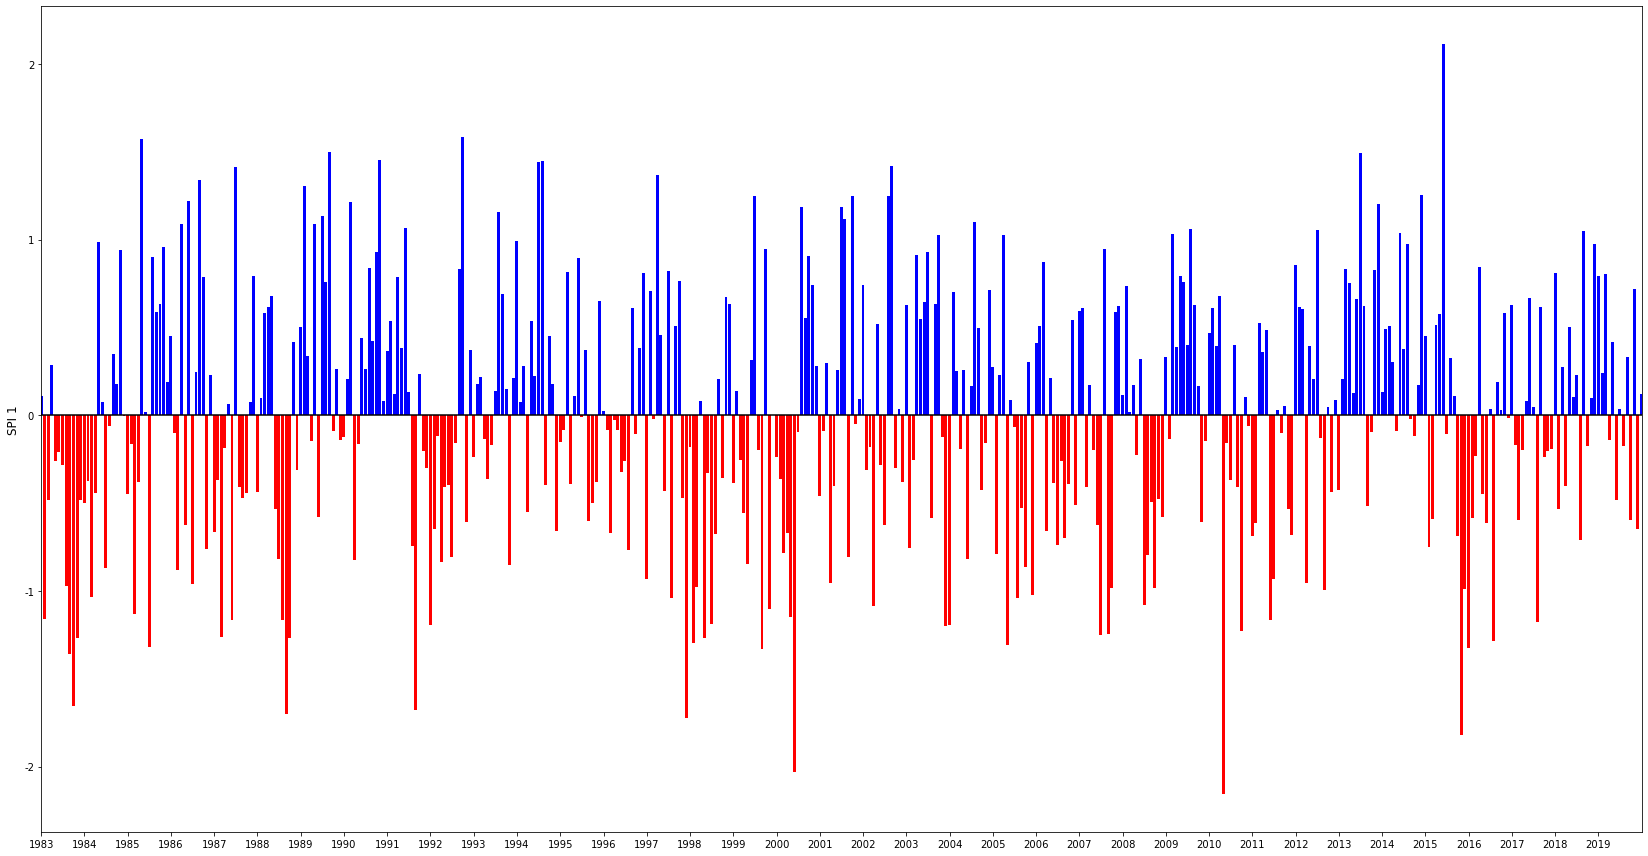

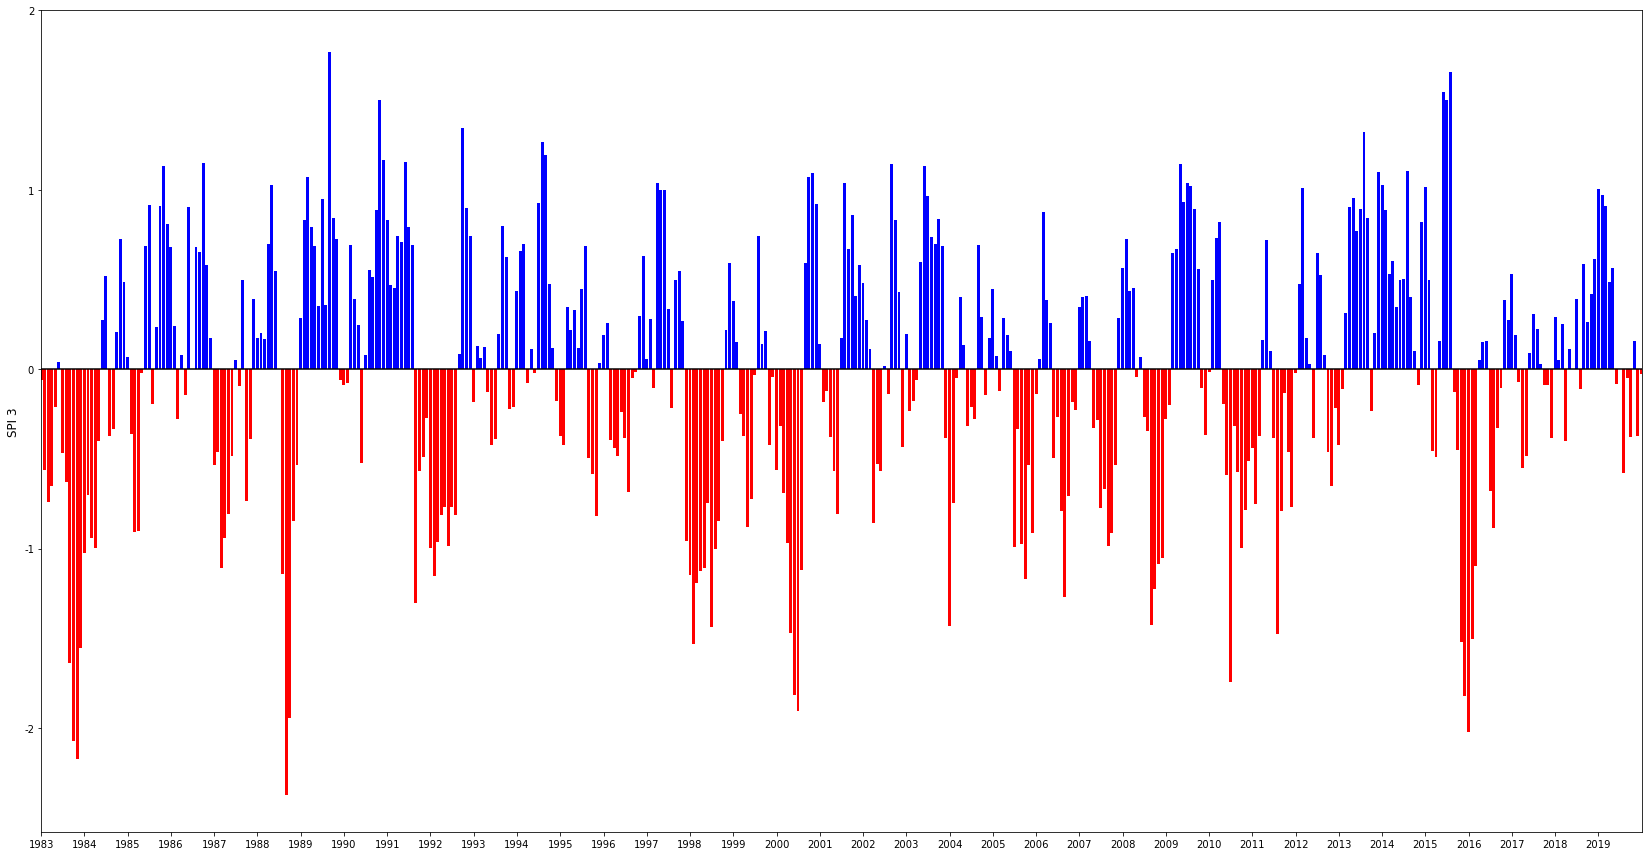

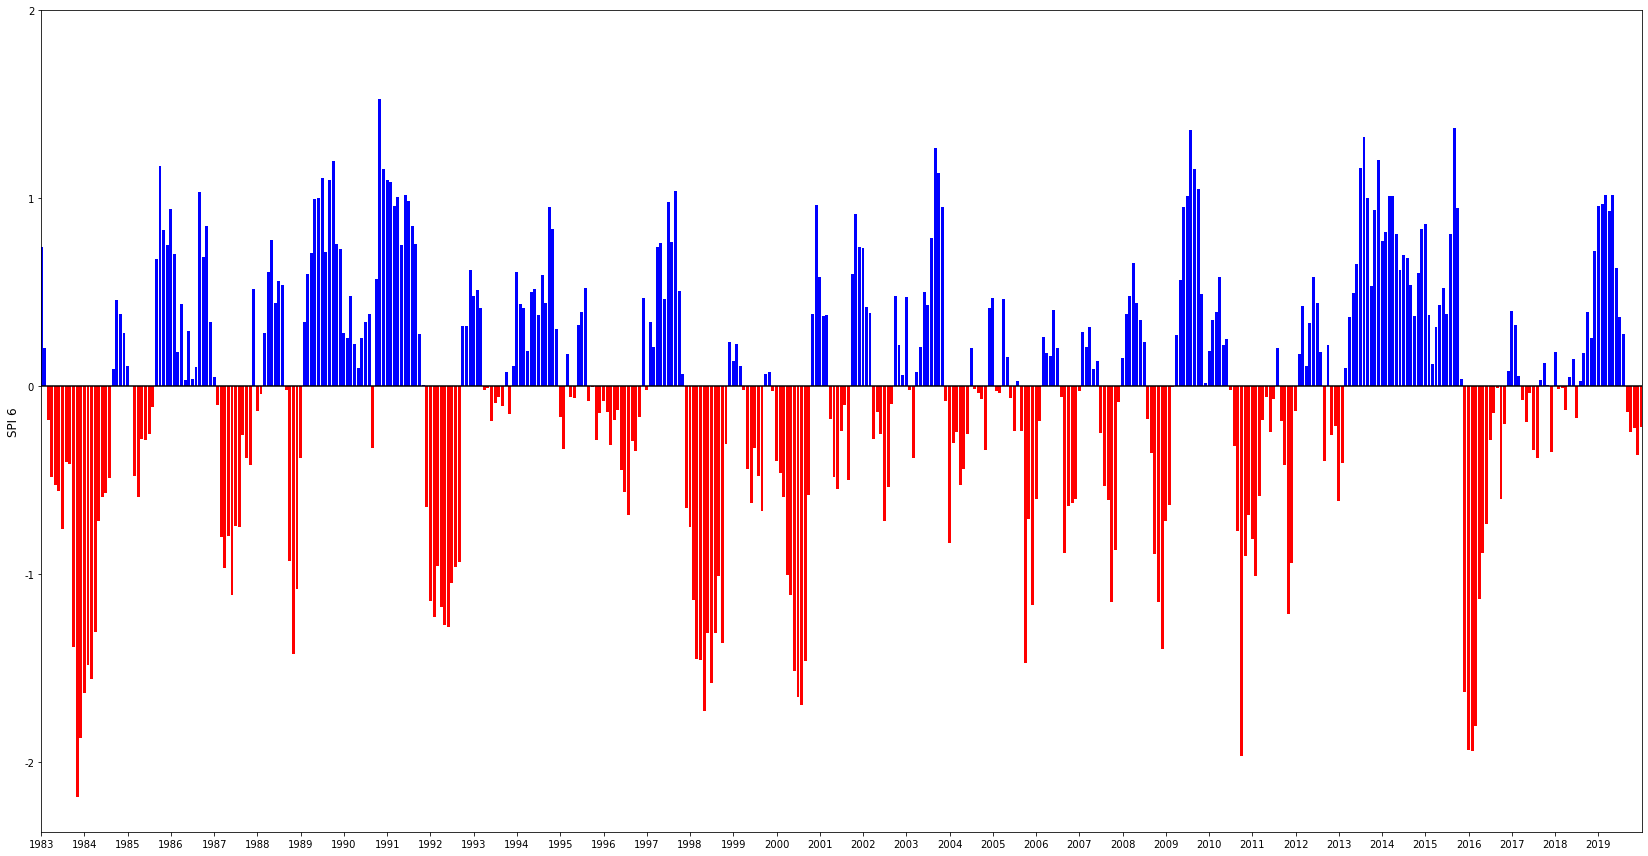

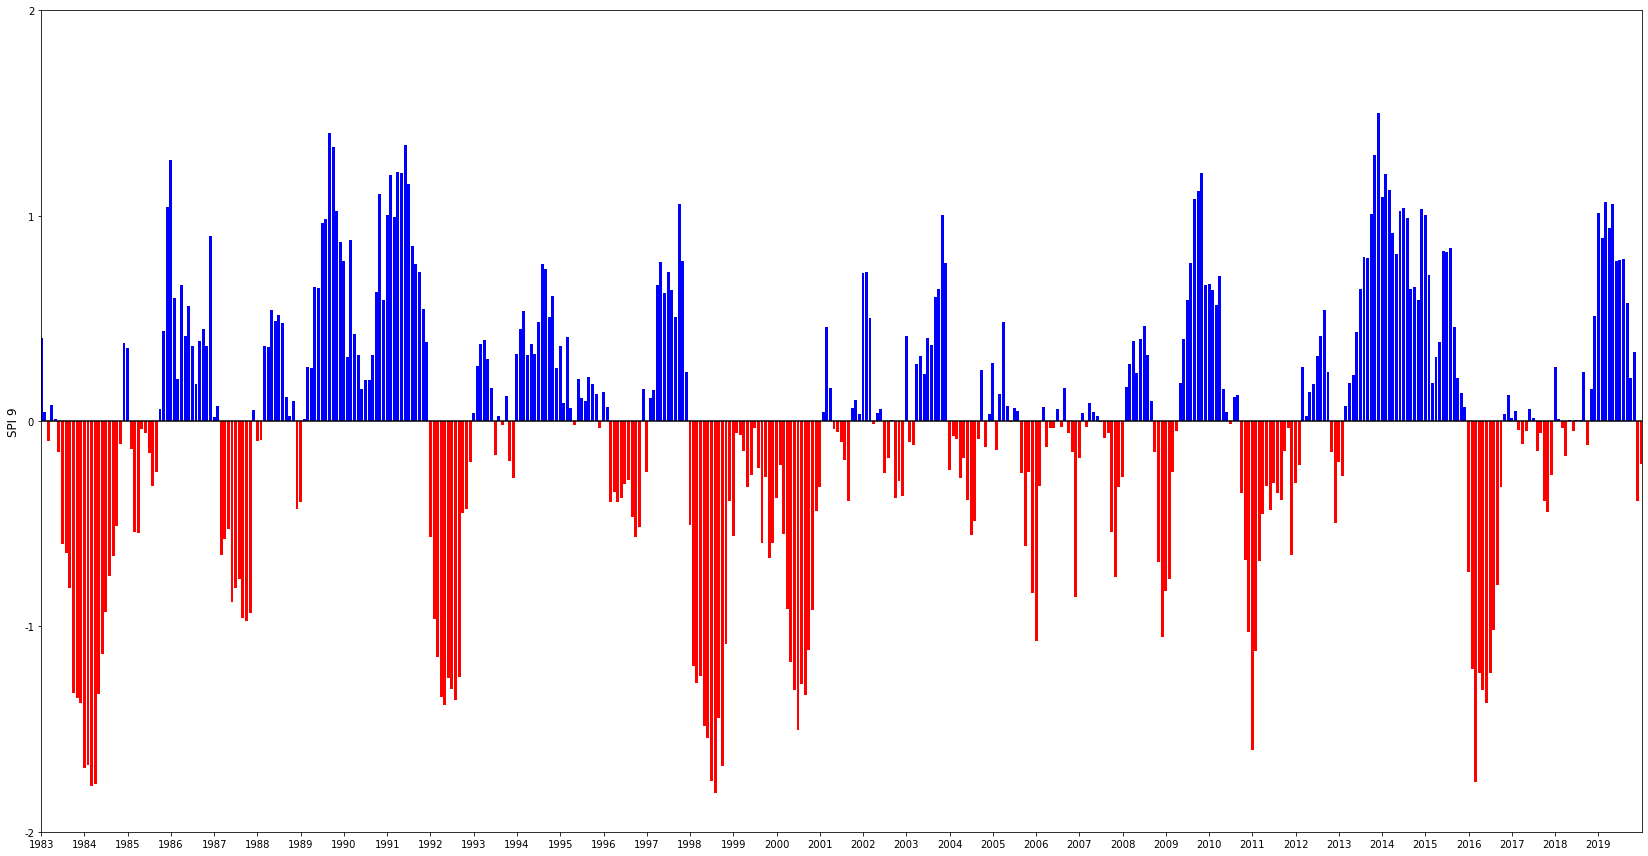

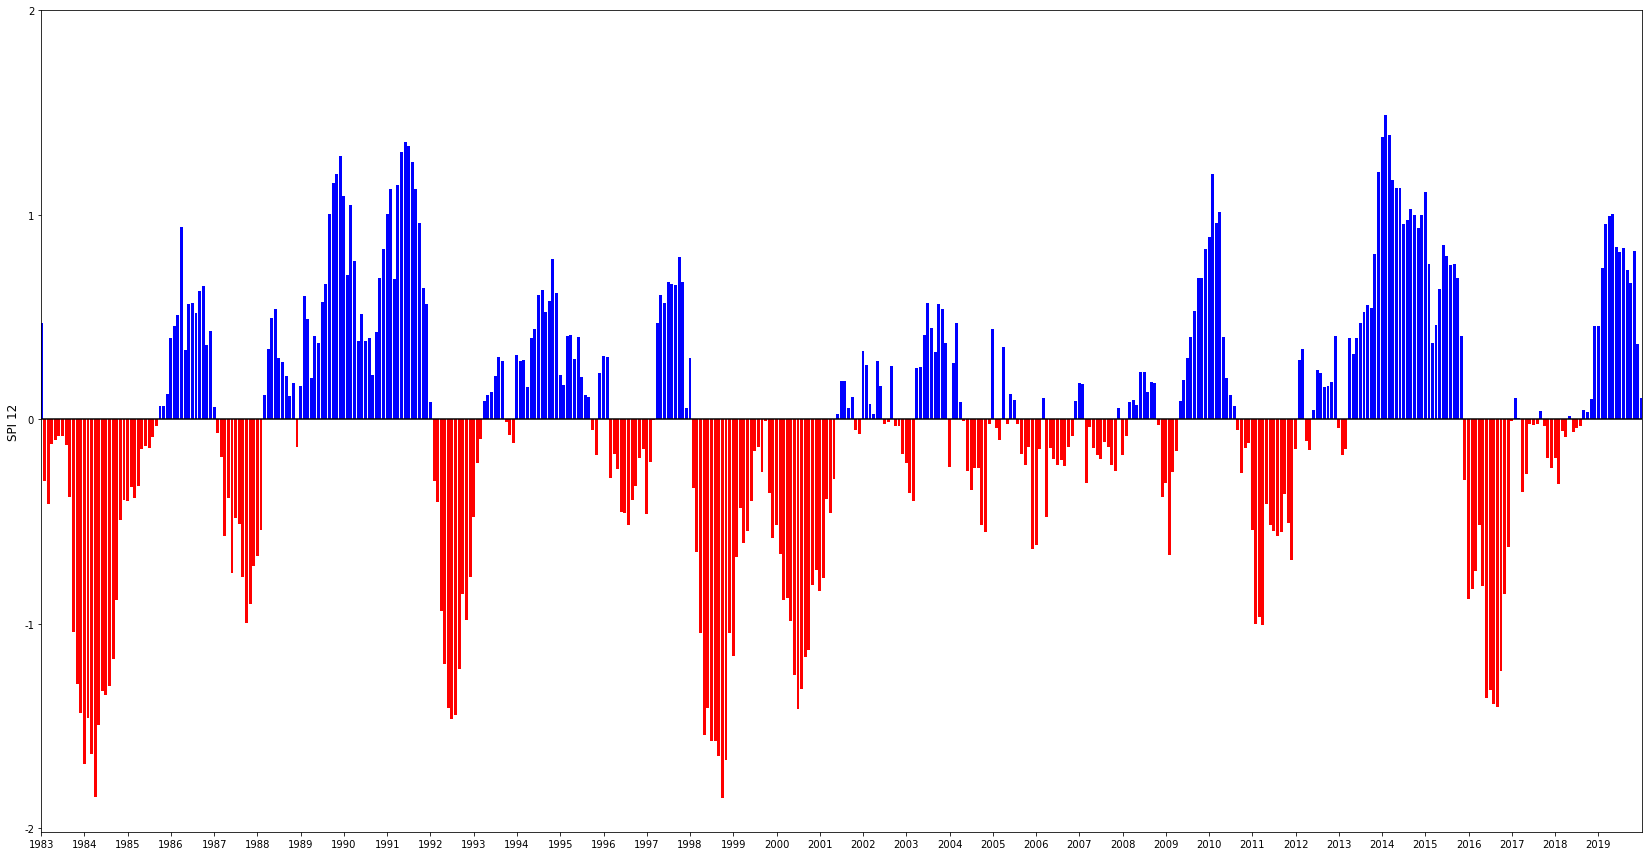

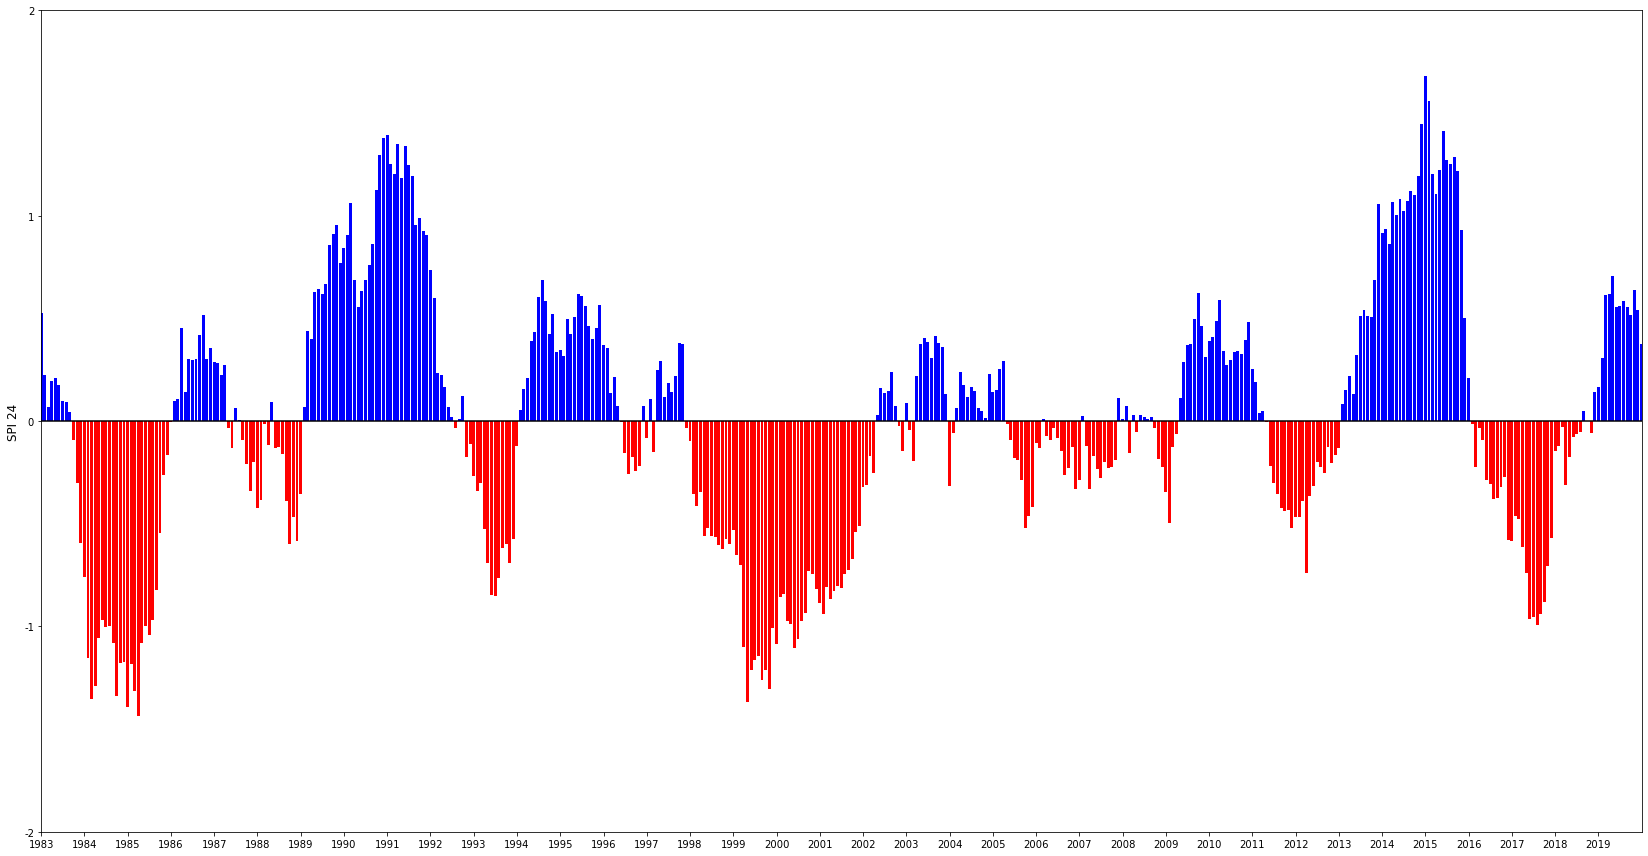

In [209]:
tipos_de_spi = [1, 3, 6, 9, 12, 24]

for i in range(len(tipos_de_spi)):
    fig, ax = plt.subplots(figsize=(23, 12))
    col_scheme = np.where(spis['SPI_'+str(tipos_de_spi[i])] > 0, 'b','r')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(spis.index, spis['SPI_'+str(tipos_de_spi[i])], width=25, align='center', color=col_scheme, label='SPI ' + str(tipos_de_spi[i]))
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.tick_params(axis='x', rotation=0)
    ax.set_yticks(range(-2,3), range(-2,3))
    ax.set_ylabel('SPI '+str(tipos_de_spi[i]), fontsize=12)
    ax.set_yticks(range(-2,3), range(-2,3))
    ax.set_xlim(dt.date(1983, 1, 1), dt.date(2019, 12, 31))
    pathsave = pathoutput + '\SPI_' + str(tipos_de_spi[i]) + ".jpeg"
    plt.tight_layout()
    fig.get_figure().savefig(pathsave,dpi=300)

#### (d) Generate rasters from each SPI considering the time-series mean

As here we are dealig with the time-series mean, we will have one SPI raster for each SPI, i.e., SPI-1mean, SPI-3mean, SPI-6mean, SPI-9mean, SPI-12mean and SPI-24mean. 

First we create a clone map just to get the information (resolution, CRS, etc)

In [12]:
path =r'C:\Users\User\OneDrive\IST\RESEARCH\5_SPI\rondonia\dnCHIRPS'
filenames = glob.glob(path + "/*.bil")
filename = filenames[0]

RasterClone = gdal.Open(filename)

geotransform = RasterClone.GetGeoTransform()

ncols = RasterClone.RasterXSize
nrows = RasterClone.RasterYSize
numtotal = ncols*nrows
xmin = RasterClone.GetGeoTransform()[0]
ymax = RasterClone.GetGeoTransform()[3]
xres = RasterClone.GetGeoTransform()[1]
yres = RasterClone.GetGeoTransform()[5]
xmax = xmin + xres*ncols
ymin = ymax - xres*nrows

print("These are the main information for our rasters:", geotransform)
print("The number of rows is:", nrows, "and the number of columns is:", ncols)

These are the main information for our rasters: (-66.83500000000001, 0.05, 0.0, -7.955, 0.0, -0.05)
The number of rows is: 115 and the number of columns is: 142


In [13]:
# We create a function to write down the MATRIX into a Raster:

def WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathoutput):

    output_raster = gdal.GetDriverByName('GTiff').Create(pathoutput,ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(4326)                                                                                                               
    output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
    output_raster.GetRasterBand(1).WriteArray(resultmatrixtotal)   # Writes my array to the raster

    output_raster.FlushCache()

At this point we can import the datasets again:

In [17]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\spis'
filenames = glob.glob(path + "/*.csv")

spi1 = pd.read_csv(filenames[0], header = None)
spi3 = pd.read_csv(filenames[1], header = None)
spi6 = pd.read_csv(filenames[2], header = None)
spi12 = pd.read_csv(filenames[4], header = None)
spi24 = pd.read_csv(filenames[5], header = None)

Calculate the time-series mean for each SPI:

In [18]:
spi1mean = np.reshape(spi1.mean().values, (nrows, ncols))
spi3mean = np.reshape(spi3.mean().values, (nrows, ncols))
spi6mean = np.reshape(spi6.mean().values, (nrows, ncols))
spi12mean = np.reshape(spi12.mean().values, (nrows, ncols))
spi24mean = np.reshape(spi24.mean().values, (nrows, ncols))

Now we can save each SPImean as a independent raster:

In [20]:
#SPI-1:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi1mean.tif'
WriteFromArrayToGTIFF(spi1mean, geotransform, pathoutput)

#SPI-3:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi3mean.tif'
WriteFromArrayToGTIFF(spi3mean, geotransform, pathoutput)

#SPI-6:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi6mean.tif'
WriteFromArrayToGTIFF(spi6mean, geotransform, pathoutput)

#SPI-12:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi12mean.tif'
WriteFromArrayToGTIFF(spi12mean, geotransform, pathoutput)

#SPI-24:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi24mean.tif'
WriteFromArrayToGTIFF(spi24mean, geotransform, pathoutput)

#### (e) Generate rasters from each SPI and for each time-step:

Now, differently than what was processed in the last step, at this point the .CSVs with the SPIS are reshaped for each month and exported as an independent raster. For instance, considering the SPI-1, one might expect to have at the end 468 rasters (1 for each month).

SPI-1:

In [149]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi1'

for monthspi in range(len(spi1)):
    resultmatrixtotal = np.reshape(spi1.iloc[monthspi, :].values, (nrows, ncols))
    
    
    monthi = spis.index[monthspi].month
    yeari = spis.index[monthspi].year
    if monthi < 10:
        datei = str(yeari) + "0" + str(monthi)
    else:
        datei = str(yeari) + str(monthi)
      
    
    pathsave = pathoutput + "\spi1" + datei + ".tif"
        
    WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathsave)

SPI-3:

In [150]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi3'

for monthspi in range(len(spi3)):
    resultmatrixtotal = np.reshape(spi3.iloc[monthspi, :].values, (nrows, ncols))
    
    
    monthi = spis.index[monthspi].month
    yeari = spis.index[monthspi].year
    if monthi < 10:
        datei = str(yeari) + "0" + str(monthi)
    else:
        datei = str(yeari) + str(monthi)
      
    
    pathsave = pathoutput + "\spi3" + datei + ".tif"
        
    WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathsave)

SPI-6:

In [151]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi6'

for monthspi in range(len(spi6)):
    resultmatrixtotal = np.reshape(spi6.iloc[monthspi, :].values, (nrows, ncols))
    
    
    monthi = spis.index[monthspi].month
    yeari = spis.index[monthspi].year
    if monthi < 10:
        datei = str(yeari) + "0" + str(monthi)
    else:
        datei = str(yeari) + str(monthi)
      
    
    pathsave = pathoutput + "\spi6" + datei + ".tif"
        
    WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathsave)

SPI-12:

In [152]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi12'

for monthspi in range(len(spi12)):
    resultmatrixtotal = np.reshape(spi12.iloc[monthspi, :].values, (nrows, ncols))
    
    
    monthi = spis.index[monthspi].month
    yeari = spis.index[monthspi].year
    if monthi < 10:
        datei = str(yeari) + "0" + str(monthi)
    else:
        datei = str(yeari) + str(monthi)
      
    
    pathsave = pathoutput + "\spi12" + datei + ".tif"
        
    WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathsave)

SPI-24:

In [145]:
pathoutput = r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi24'

for monthspi in range(len(spi24)):
    resultmatrixtotal = np.reshape(spi24.iloc[monthspi, :].values, (nrows, ncols))
    
    
    monthi = spis.index[monthspi].month
    yeari = spis.index[monthspi].year
    if monthi < 10:
        datei = str(yeari) + "0" + str(monthi)
    else:
        datei = str(yeari) + str(monthi)
      
    
    pathsave = pathoutput + "\spi24" + datei + ".tif"
        
    WriteFromArrayToGTIFF(resultmatrixtotal, geotransform, pathsave)

#### (f) Plot of all the rasters from SPI-1 in a single figure:

In [342]:
from shapely.geometry import mapping
from tqdm import tqdm

In [ ]:
#lidar_chm = rxr.open_rasterio(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi24\spi24201912.tif').squeeze()
#fire_boundary = gpd.read_file(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\gis\rondonia.shp')
#lidar_clipped = lidar_chm.rio.clip(fire_boundary.geometry.apply(mapping))

We import the rondonia.shp:

In [318]:
fire_boundary = gpd.read_file(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\gis\rondonia.shp')

Now we retrieve the filenames (paths) for each raster:

In [361]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi1'
filenames = glob.glob(path + "/*.tif")

We then divide in two figures since it would not be possible to plot all together (468 figs):

I. 1981 untill 2000 (20 years)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [07:15<00:00,  1.82s/it]


Text(0.5, 1.0, 'Dec')

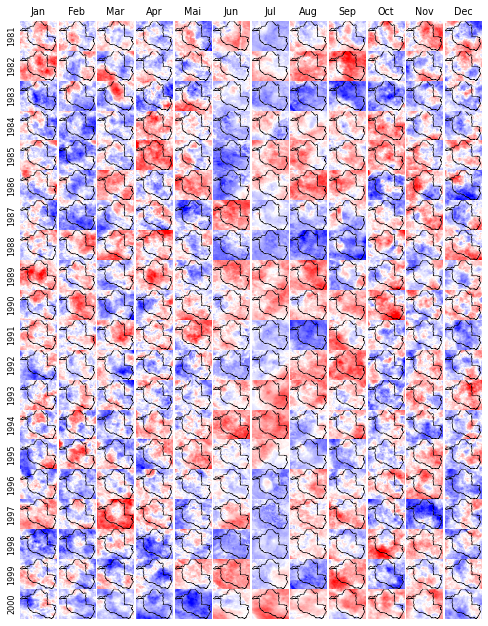

In [360]:
fig, axs = plt.subplots(20,12, figsize=(8.3, 11))
plt.subplots_adjust(hspace=0.0, wspace = 0.0)
num_rows = axs.shape[0]
num_cols = axs.shape[1]
colauxs = [*range(num_cols)] * num_rows
rowauxs = [i for i in range(num_rows) for _ in range(num_cols)] 

i = 0
for col in tqdm(range(240)):
    lidar_chm = rxr.open_rasterio(filenames[i]).squeeze()

    
    colaux, rowaux = colauxs[i], rowauxs[i]
    chm_plot = axs[rowaux,colaux].imshow(lidar_chm,origin = 'upper',cmap = "bwr", vmin=-3, vmax=3, extent=[xmin,xmax,ymin,ymax])
    fire_boundary.plot(ax=axs[rowaux,colaux], facecolor = "none", linewidth = 0.5)
    #axs[rowaux,colaux].axis('off')
    
    axs[rowaux,colaux].set_yticklabels([])
    axs[rowaux,colaux].set_xticklabels([])
    
    axs[rowaux,colaux].set_xticks([])
    axs[rowaux,colaux].set_yticks([])
    
    axs[rowaux,colaux].spines['top'].set_visible(False)
    axs[rowaux,colaux].spines['right'].set_visible(False)
    axs[rowaux,colaux].spines['left'].set_visible(False)
    axs[rowaux,colaux].spines['bottom'].set_visible(False)

    
    
    if colaux == 0:
        yeari = spis.index[i].year
        axs[rowaux,colaux].set_ylabel(str(yeari))

    i = i + 1
    
    
axs[0,0].set_title("Jan")
axs[0,1].set_title("Feb")
axs[0,2].set_title("Mar")
axs[0,3].set_title("Apr")
axs[0,4].set_title("Mai")
axs[0,5].set_title("Jun")
axs[0,6].set_title("Jul")
axs[0,7].set_title("Aug")
axs[0,8].set_title("Sep")
axs[0,9].set_title("Oct")
axs[0,10].set_title("Nov")
axs[0,11].set_title("Dec")


#axs[0,0].set_ylabel(str(yeari))

In [362]:
fig.get_figure().savefig(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs\spi1all.jpeg',dpi=300)

II. 2001 untill 2019 (19 years):

100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [06:15<00:00,  1.65s/it]


Text(0.5, 1.0, 'Dec')

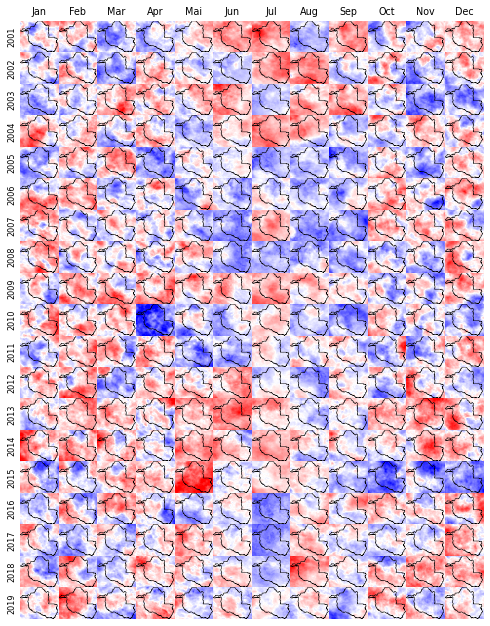

In [371]:
fig, axs = plt.subplots(19,12, figsize=(8.3, 11))
plt.subplots_adjust(hspace=0.0, wspace = 0.0)
num_rows = axs.shape[0]
num_cols = axs.shape[1]
colauxs = [*range(num_cols)] * num_rows
rowauxs = [i for i in range(num_rows) for _ in range(num_cols)] 

i = 0
for col in tqdm(range(240, 468)):
    lidar_chm = rxr.open_rasterio(filenames[col]).squeeze()

    
    colaux, rowaux = colauxs[i], rowauxs[i]
    chm_plot = axs[rowaux,colaux].imshow(lidar_chm,origin = 'upper',cmap = "bwr", vmin=-3, vmax=3, extent=[xmin,xmax,ymin,ymax])
    fire_boundary.plot(ax=axs[rowaux,colaux], facecolor = "none", linewidth = 0.5)
    #axs[rowaux,colaux].axis('off')
    
    axs[rowaux,colaux].set_yticklabels([])
    axs[rowaux,colaux].set_xticklabels([])
    
    axs[rowaux,colaux].set_xticks([])
    axs[rowaux,colaux].set_yticks([])
    
    axs[rowaux,colaux].spines['top'].set_visible(False)
    axs[rowaux,colaux].spines['right'].set_visible(False)
    axs[rowaux,colaux].spines['left'].set_visible(False)
    axs[rowaux,colaux].spines['bottom'].set_visible(False)

    
    
    if colaux == 0:
        yeari = spis.index[col].year
        axs[rowaux,colaux].set_ylabel(str(yeari))

    i = i + 1
    
    
axs[0,0].set_title("Jan")
axs[0,1].set_title("Feb")
axs[0,2].set_title("Mar")
axs[0,3].set_title("Apr")
axs[0,4].set_title("Mai")
axs[0,5].set_title("Jun")
axs[0,6].set_title("Jul")
axs[0,7].set_title("Aug")
axs[0,8].set_title("Sep")
axs[0,9].set_title("Oct")
axs[0,10].set_title("Nov")
axs[0,11].set_title("Dec")


#axs[0,0].set_ylabel(str(yeari))

In [372]:
fig.get_figure().savefig(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs\spi1allpart2.jpeg',dpi=300)

#### (g) Plot of all the rasters from SPI-24 in a single figure:

Now we retrieve the filenames (paths) for each raster:

In [373]:
path =r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\tifs\spi24'
filenames = glob.glob(path + "/*.tif")

We then divide in two figures since it would not be possible to plot all together (468 figs):

I. 1981 untill 2000 (20 years)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [06:46<00:00,  1.69s/it]


Text(0.5, 1.0, 'Dec')

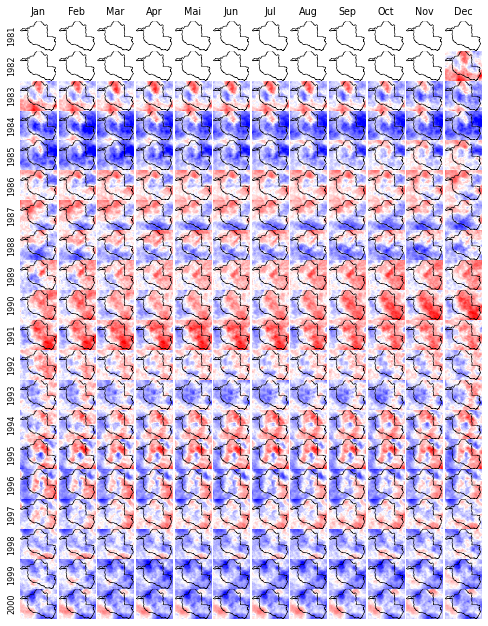

In [375]:
fig, axs = plt.subplots(20,12, figsize=(8.3, 11))
plt.subplots_adjust(hspace=0.0, wspace = 0.0)
num_rows = axs.shape[0]
num_cols = axs.shape[1]
colauxs = [*range(num_cols)] * num_rows
rowauxs = [i for i in range(num_rows) for _ in range(num_cols)] 

i = 0
for col in tqdm(range(240)):
    lidar_chm = rxr.open_rasterio(filenames[i]).squeeze()

    
    colaux, rowaux = colauxs[i], rowauxs[i]
    chm_plot = axs[rowaux,colaux].imshow(lidar_chm,origin = 'upper',cmap = "bwr", vmin=-3, vmax=3, extent=[xmin,xmax,ymin,ymax])
    fire_boundary.plot(ax=axs[rowaux,colaux], facecolor = "none", linewidth = 0.5)
    #axs[rowaux,colaux].axis('off')
    
    axs[rowaux,colaux].set_yticklabels([])
    axs[rowaux,colaux].set_xticklabels([])
    
    axs[rowaux,colaux].set_xticks([])
    axs[rowaux,colaux].set_yticks([])
    
    axs[rowaux,colaux].spines['top'].set_visible(False)
    axs[rowaux,colaux].spines['right'].set_visible(False)
    axs[rowaux,colaux].spines['left'].set_visible(False)
    axs[rowaux,colaux].spines['bottom'].set_visible(False)

    
    
    if colaux == 0:
        yeari = spis.index[i].year
        axs[rowaux,colaux].set_ylabel(str(yeari))

    i = i + 1
    
    
axs[0,0].set_title("Jan")
axs[0,1].set_title("Feb")
axs[0,2].set_title("Mar")
axs[0,3].set_title("Apr")
axs[0,4].set_title("Mai")
axs[0,5].set_title("Jun")
axs[0,6].set_title("Jul")
axs[0,7].set_title("Aug")
axs[0,8].set_title("Sep")
axs[0,9].set_title("Oct")
axs[0,10].set_title("Nov")
axs[0,11].set_title("Dec")


#axs[0,0].set_ylabel(str(yeari))

In [376]:
fig.get_figure().savefig(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs\spi24allpart1.jpeg',dpi=300)

II. 2001 untill 2019 (19 years):

100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [06:40<00:00,  1.76s/it]


Text(0.5, 1.0, 'Dec')

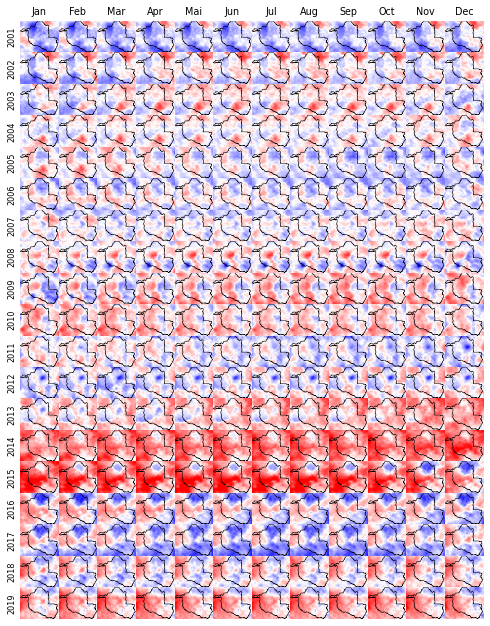

In [377]:
fig, axs = plt.subplots(19,12, figsize=(8.3, 11))
plt.subplots_adjust(hspace=0.0, wspace = 0.0)
num_rows = axs.shape[0]
num_cols = axs.shape[1]
colauxs = [*range(num_cols)] * num_rows
rowauxs = [i for i in range(num_rows) for _ in range(num_cols)] 

i = 0
for col in tqdm(range(240, 468)):
    lidar_chm = rxr.open_rasterio(filenames[col]).squeeze()

    
    colaux, rowaux = colauxs[i], rowauxs[i]
    chm_plot = axs[rowaux,colaux].imshow(lidar_chm,origin = 'upper',cmap = "bwr", vmin=-3, vmax=3, extent=[xmin,xmax,ymin,ymax])
    fire_boundary.plot(ax=axs[rowaux,colaux], facecolor = "none", linewidth = 0.5)
    #axs[rowaux,colaux].axis('off')
    
    axs[rowaux,colaux].set_yticklabels([])
    axs[rowaux,colaux].set_xticklabels([])
    
    axs[rowaux,colaux].set_xticks([])
    axs[rowaux,colaux].set_yticks([])
    
    axs[rowaux,colaux].spines['top'].set_visible(False)
    axs[rowaux,colaux].spines['right'].set_visible(False)
    axs[rowaux,colaux].spines['left'].set_visible(False)
    axs[rowaux,colaux].spines['bottom'].set_visible(False)

    
    
    if colaux == 0:
        yeari = spis.index[col].year
        axs[rowaux,colaux].set_ylabel(str(yeari))

    i = i + 1
    
    
axs[0,0].set_title("Jan")
axs[0,1].set_title("Feb")
axs[0,2].set_title("Mar")
axs[0,3].set_title("Apr")
axs[0,4].set_title("Mai")
axs[0,5].set_title("Jun")
axs[0,6].set_title("Jul")
axs[0,7].set_title("Aug")
axs[0,8].set_title("Sep")
axs[0,9].set_title("Oct")
axs[0,10].set_title("Nov")
axs[0,11].set_title("Dec")


#axs[0,0].set_ylabel(str(yeari))

In [379]:
fig.get_figure().savefig(r'C:\Users\User\OneDrive\Projects\Y2022\SPI-Rondonia\rondonia\figs\spi24allpart2.jpeg',dpi=300)